In [1]:
import sys
print("Current Python interpreter:", sys.executable)
print("Version:", sys.version)

Current Python interpreter: /workspaces/eng-ai-agents/.venv/bin/python
Version: 3.11.9 (main, Aug 14 2024, 03:58:18) [GCC 6.3.0 20170516]


In [2]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

device

device(type='cpu')

## Q1 Information Theory

In [3]:
import torch

p = torch.tensor([
    [1/8, 1/16, 1/32, 1/32],
    [1/16, 1/8, 1/32, 1/32],
    [1/16, 1/16, 1/16, 1/16],
    [1/4,  0,    0,    0]
], dtype=torch.float)

px = p.sum(dim=0)
py = p.sum(dim=1)

def e(a):
    m = a>0
    b = a[m]
    return -(b*torch.log2(b)).sum()

hx = e(px)
hy = e(py)
hxy = e(p.view(-1))
hxgy = hxy - hy
hygx = hxy - hx

### a

In [4]:
val_a = abs(hxgy.item() - hygx.item())

if val_a < 1e-9:
    print("Yes")
else:
    print("No")

No


### b

In [5]:
lhs = hx - hxgy
rhs = hy - hygx
val_b = abs(lhs.item() - rhs.item())

if val_b < 1e-9:
    print("Yes")
else:
    print("No")

Yes


### c
$ I(X;Y) = H(X) + H(Y) - H(X, Y) $

In [6]:
ixy = hx + hy - hxy
print(ixy.item())

0.375


## Q2 MLE

### Task1

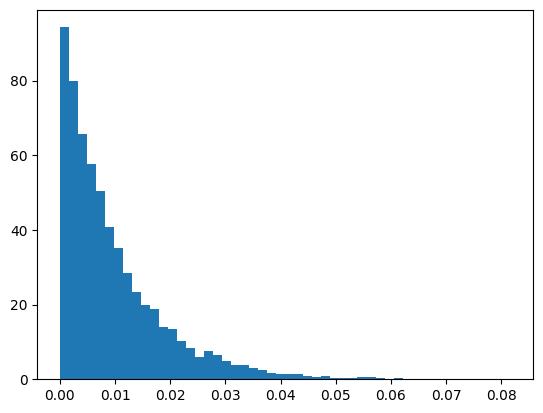

In [7]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
l=100
n=10000
x=np.random.exponential(1/l,n)
plt.hist(x,bins=50,density=True)
plt.show()

### Task 2
$\text{negll}(a,b) = -\log(b) + b \cdot a$


a 38.464426318536866


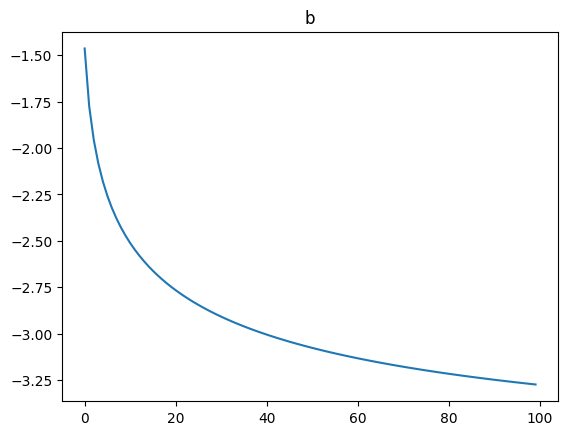

In [8]:
lr=0.001
ep=100
p=1.0
h=[]
def negll(a,b):
    return -np.log(b)+b*a
for _ in range(ep):
    idx=np.random.permutation(n)
    for i in idx:
        g=-1/p + x[i]
        p-=lr*g
    h.append(np.mean([negll(v,p) for v in x]))
print("a", p)
plt.plot(h)
plt.title("b")
plt.show()

## Q3 Linear Regression

In [9]:
# pip install git+https://github.com/ctgk/PRML.git

## use data from course site

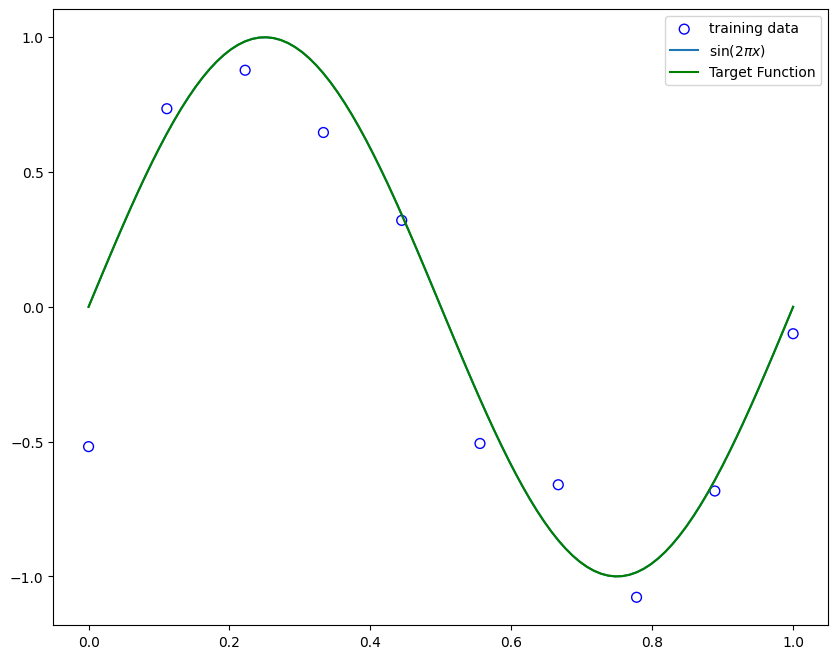

In [10]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

from prml.preprocess import GaussianFeature, PolynomialFeature, SigmoidalFeature
from prml.linear import (
    BayesianRegression,
    EmpiricalBayesRegression,
    LinearRegression,
    RidgeRegression
)

np.random.seed(1234)

def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    y = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, y

def sinusoidal(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

plt.figure(figsize=[10,8])
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, label="$\sin(2\pi x)$")
plt.plot(x_test, y_test, "-g", label="Target Function")
plt.legend()
plt.show()

loss function with L2 regularization:
$
L = \frac{1}{N} \sum_{i=1}^{N} (y_i - X_i \mathbf{w})^2 + \lambda \|\mathbf{w}\|_2^2
$

N umber of samples,
w represents the model parameters,
X is the input feature matrix,
y is the target variable,
lambda is the regularization strength.

weight update rule:

$
\mathbf{w} := \mathbf{w} - \eta \left( \frac{1}{B} X^T (X \mathbf{w} - y) + \lambda \mathbf{w} \right)
$



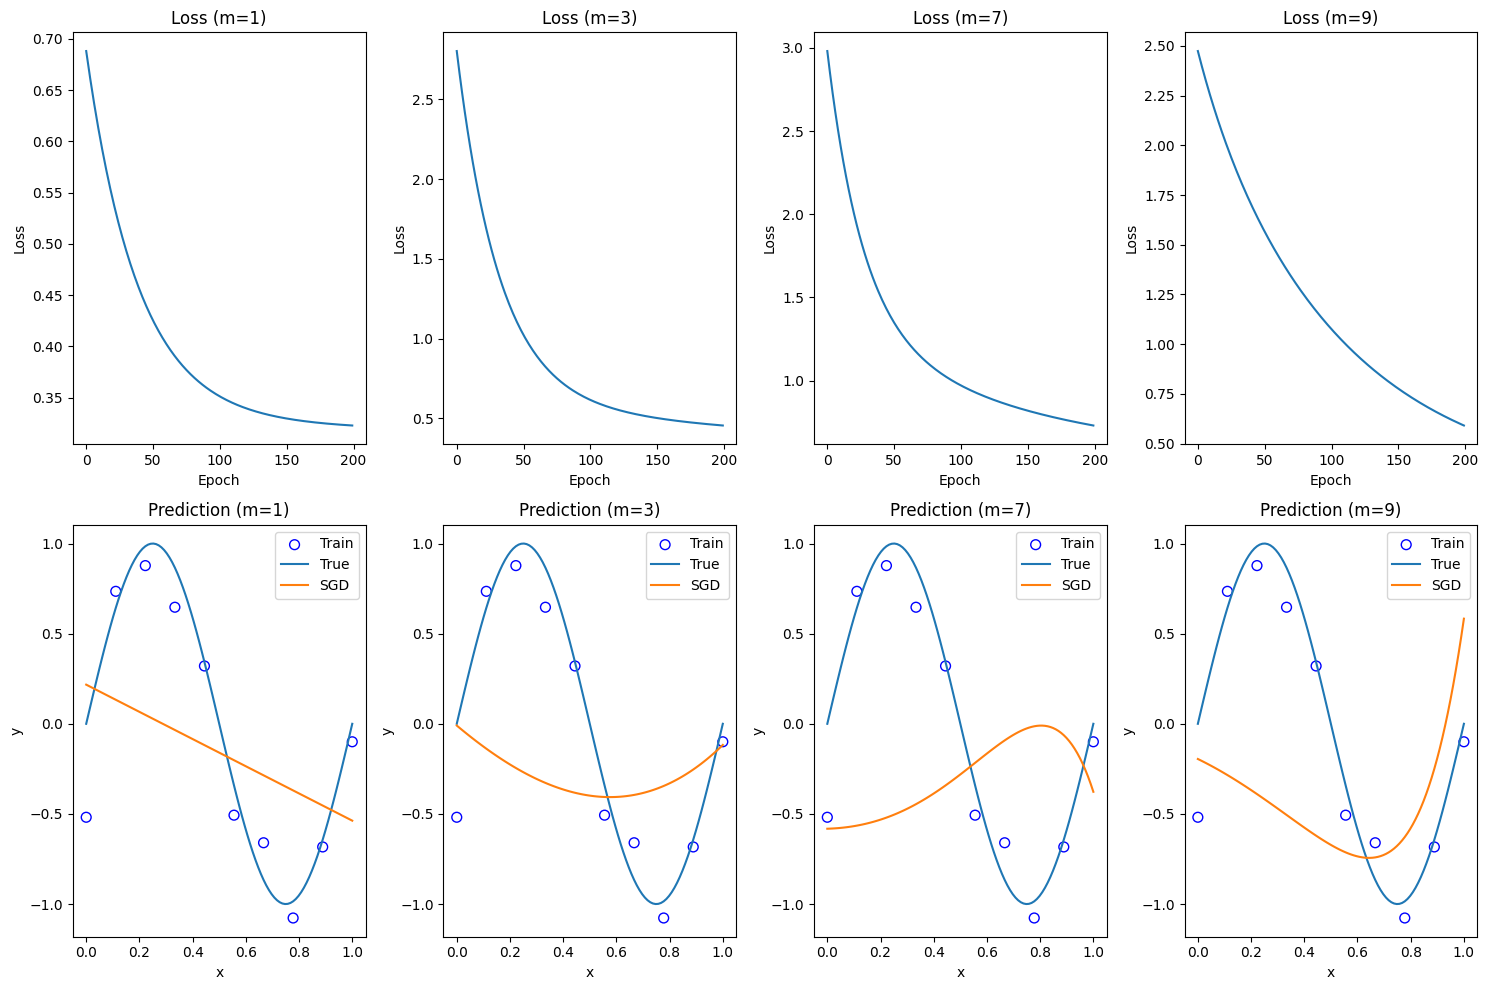

w for m=1: [-0.53328144  0.55647295]
w for m=3: [-0.88673838  1.01681163 -0.1247387   0.06641133]
w for m=7: [-0.29537875  0.02797653  0.73599401  0.98054751 -0.7974637   0.81011466
 -2.0074157  -0.27039915]
w for m=9: [-0.51133563  0.73180998  0.54172587  0.02701996 -0.91725309 -0.61651822
  0.05623934 -0.40497186 -0.44463374  0.93360893]


In [11]:
class SGD:
    def __init__(self, lr=0.01, reg=0.1, epochs=100, bs=1):
        self.lr = lr
        self.reg = reg
        self.epochs = epochs
        self.bs = bs
        self.losses = []

    def fit(self, X, y):
        n, d = X.shape
        self.w = np.random.randn(d)

        for _ in range(self.epochs):
            idx = np.random.permutation(n)
            X, y = X[idx], y[idx]

            for i in range(0, n, self.bs):
                Xb, yb = X[i:i+self.bs], y[i:i+self.bs]
                pred = np.dot(Xb, self.w)
                err = pred - yb
                grad = np.dot(Xb.T, err) / self.bs + self.reg * self.w
                self.w -= self.lr * grad

            pred_all = np.dot(X, self.w)
            loss = np.mean((pred_all - y) ** 2) + self.reg * np.sum(self.w ** 2)
            self.losses.append(loss)

    def predict(self, X):
        return np.dot(X, self.w)

lr = 0.01
reg = 1e-3
epochs = 200
bs = 10
m_vals = [1, 3, 7, 9]
plt.figure(figsize=[15, 10])

for i, m in enumerate(m_vals):
    feat = PolynomialFeature(m)
    Xt = feat.transform(x_train[:, np.newaxis])
    Xts = feat.transform(x_test[:, np.newaxis])

    sgd = SGD(lr=lr, reg=reg, epochs=epochs, bs=bs)
    sgd.fit(Xt, y_train)

    plt.subplot(2, len(m_vals), i + 1)
    plt.plot(range(epochs), sgd.losses)
    plt.title(f"Loss (m={m})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    y_pred = sgd.predict(Xts)

    plt.subplot(2, len(m_vals), i + 1 + len(m_vals))
    plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="Train")
    plt.plot(x_test, y_test, label="True")
    plt.plot(x_test, y_pred, label="SGD")
    plt.title(f"Prediction (m={m})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()

plt.tight_layout()
plt.show()

for m in m_vals:
    feat = PolynomialFeature(m)
    Xt = feat.transform(x_train[:, np.newaxis])
    sgd = SGD(lr=lr, reg=reg, epochs=epochs, bs=bs)
    sgd.fit(Xt, y_train)
    print(f"w for m={m}:", sgd.w)